# Laminar ROI analysis of power in source space

This tutorial demonstrates how to perform laminar inference using an ROI analysis of power in source space, described in [Bonaiuto et al., 2018, Non-invasive laminar inference with MEG: Comparison of methods and source inversion algorithms](https://doi.org/10.1016/j.neuroimage.2017.11.068), and used in [Bonaiuto et al., 2018, Lamina-specific cortical dynamics in human visual and sensorimotor cortices](https://doi.org/10.7554/eLife.33977). A 20Hz oscillation is simulated at a particular cortical location in various layers. Source reconstruction is performed using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on a multilayer mesh, thus providing an estimate of source activity on each layer. An ROI is defined by comparing power in the 10-30 Hz frequency band during the time period containing the simulated activity with a prior baseline period at each vertex using paired t-tests. Vertices in either surface with a t-statistic above a percentile threshold of the t-statistics over all vertices in that surface, as well as the corresponding vertices in the other surface, are included in the ROI. This ensures that the contrast used to define the ROI was orthogonal to the subsequent laminar contrast. For each trial, ROI values for each layer are computed by averaging the absolute value of the change in power compared to baseline in that surface within the ROI. Finally, a paired t-test is used to compare the ROI values from each layer over trials. All t-tests are done using corrected noise variance estimates in order to attenuate artifactually high significance values [Ridgway et al., 2012](https://doi.org/10.1016/j.neuroimage.2011.10.027).

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from scipy import stats
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import invert_ebb, coregister, load_source_time_series
from lameg.simulate import run_current_density_simulation
from lameg.surf import interpolate_data
from lameg.viz import show_surface, color_map
from lameg.util import ttest_rel_corrected

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas = [0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa = [-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa = [76.02110531729883, 18.9467849625573, -25.779407159603114]

# Data file to base simulations on
data_file = os.path.join(
    '../test_data/processed', 
    subj_id, 
    ses_id, 
    'spm/spm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

For source reconstructions, we need an MRI and a surface mesh. The simulations and source reconstructions will be based on a forward model using the multilayer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data/spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_output', subj_id, 'multilayer.11.ds.link_vector.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_output', subj_id, 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_output', subj_id, 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/roi'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes
)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


## Simulating a signal on the pial surface
We're going to simulate 1s of signal with a 20Hz sine wave that starts at 0.5s with a dipole moment of 10nAm

Text(0, 0.5, 'Amplitude (nAm)')

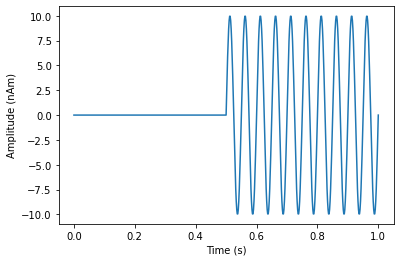

In [5]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 600

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(0,1,s_rate+1)
sim_signal = np.zeros(time.shape).reshape(1,-1)
t_idx=np.where(time>=0.5)[0]
sim_signal[0,t_idx] = np.sin(time[t_idx]*freq*2*np.pi)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

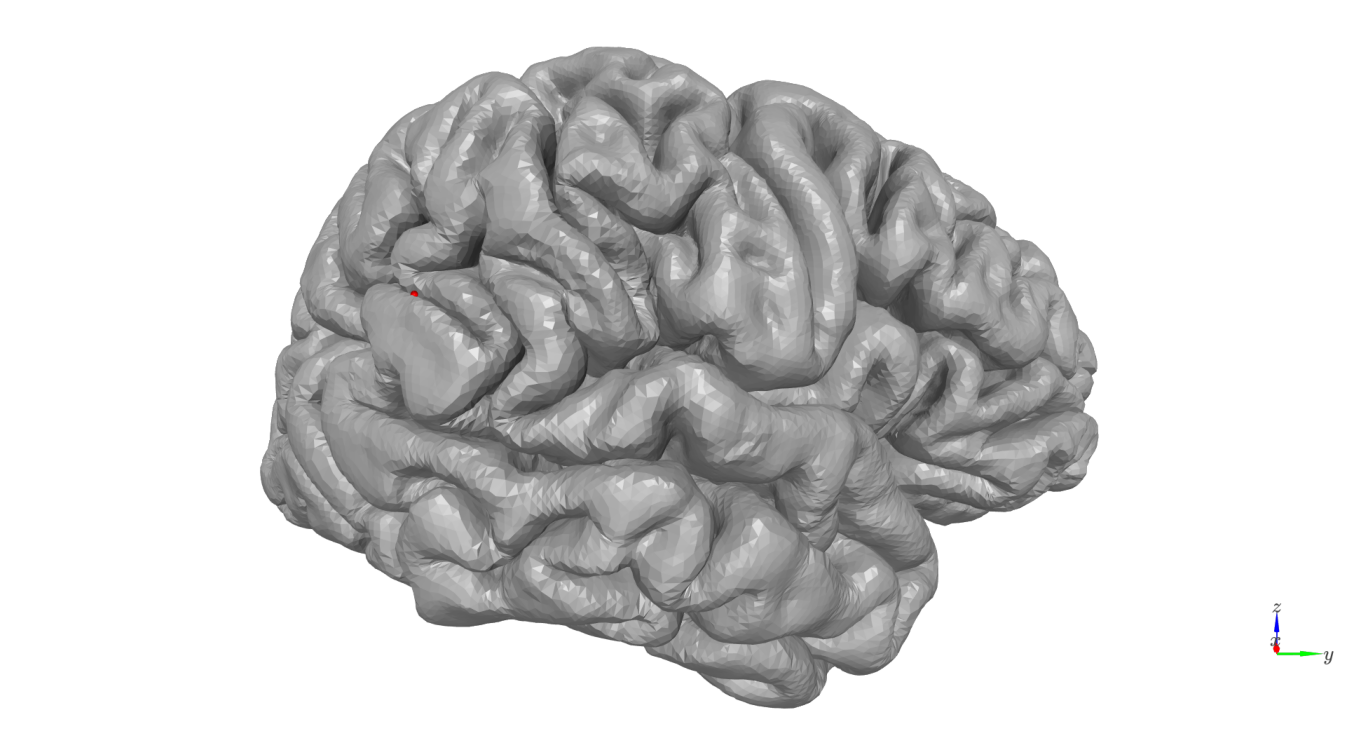

In [15]:
# Vertex to simulate activity at
sim_vertex=24588

pial_ds_mesh_fname = os.path.join('../test_output', subj_id, 'pial.ds.link_vector.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_output', subj_id, 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [7]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
prefix = f'sim_{sim_vertex}_pial.'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -10

# Generate simulated data
pial_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    dipole_moment, 
    sim_patch_size, 
    SNR
)   

## Laminar comparison (pial - white matter)
Now we can run source reconstruction using a source model based on the multi-laminar surface, define an ROI based on the change in power from a baseline time period, and then compare the change in power between the pial and white matter surfaces. First we'll run the inversion and get the source time series for all the vertices on the pial and white matter surfaces.

In [8]:
# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    pial_sim_fname
)

# Run inversion on simulated data in a 5Hz window around the simulated frequency using the multilayer surface
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    pial_sim_fname, 
    n_layers, 
    foi=[freq-10, freq+10],
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes, 
    return_mu_matrix=True
)

# Get pial and white source time series
pial_vertices = np.arange(verts_per_surf)
white_vertices = (n_layers-1)*verts_per_surf+np.arange(verts_per_surf)
pial_layer_ts, time = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_vertices
)
white_layer_ts, time = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=white_vertices
)

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


First we'll compute the change in power from baseline for the pial and white matter surfaces and visualize it on the original (non-downsampled) inflated surface

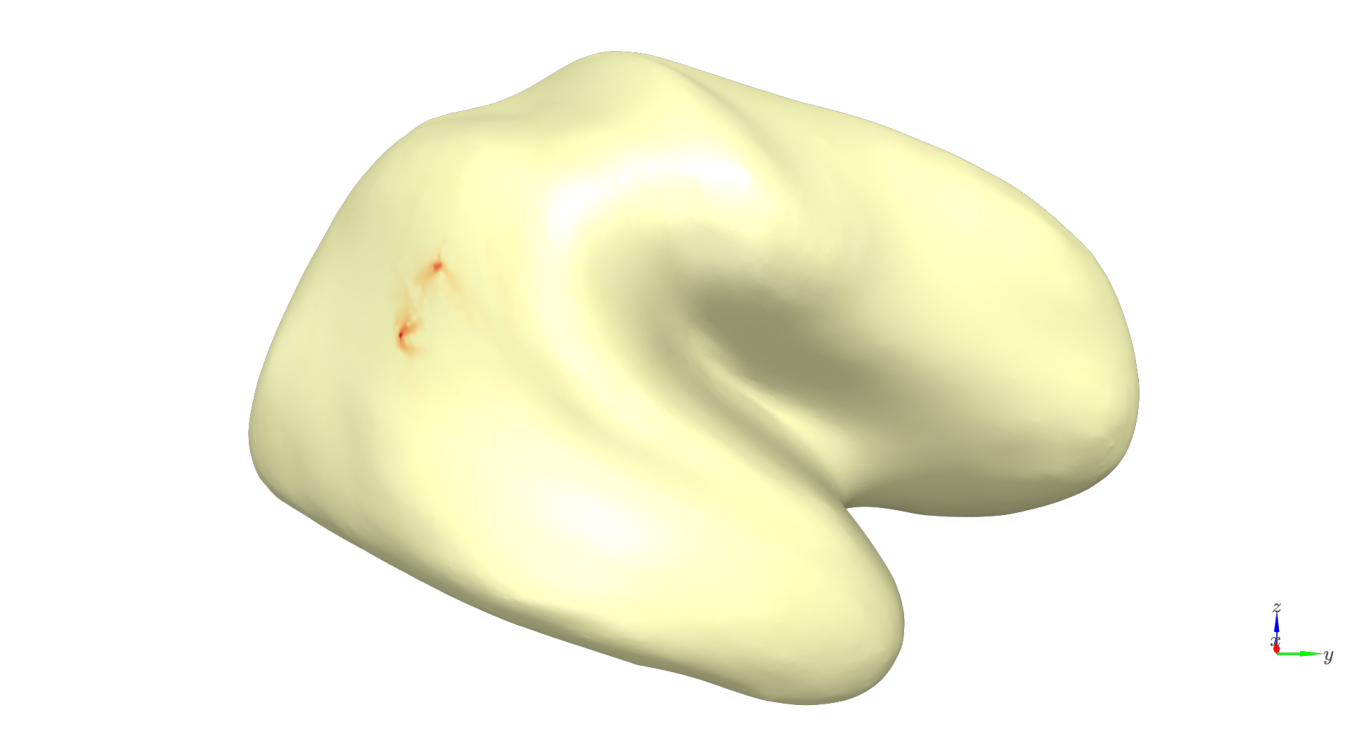

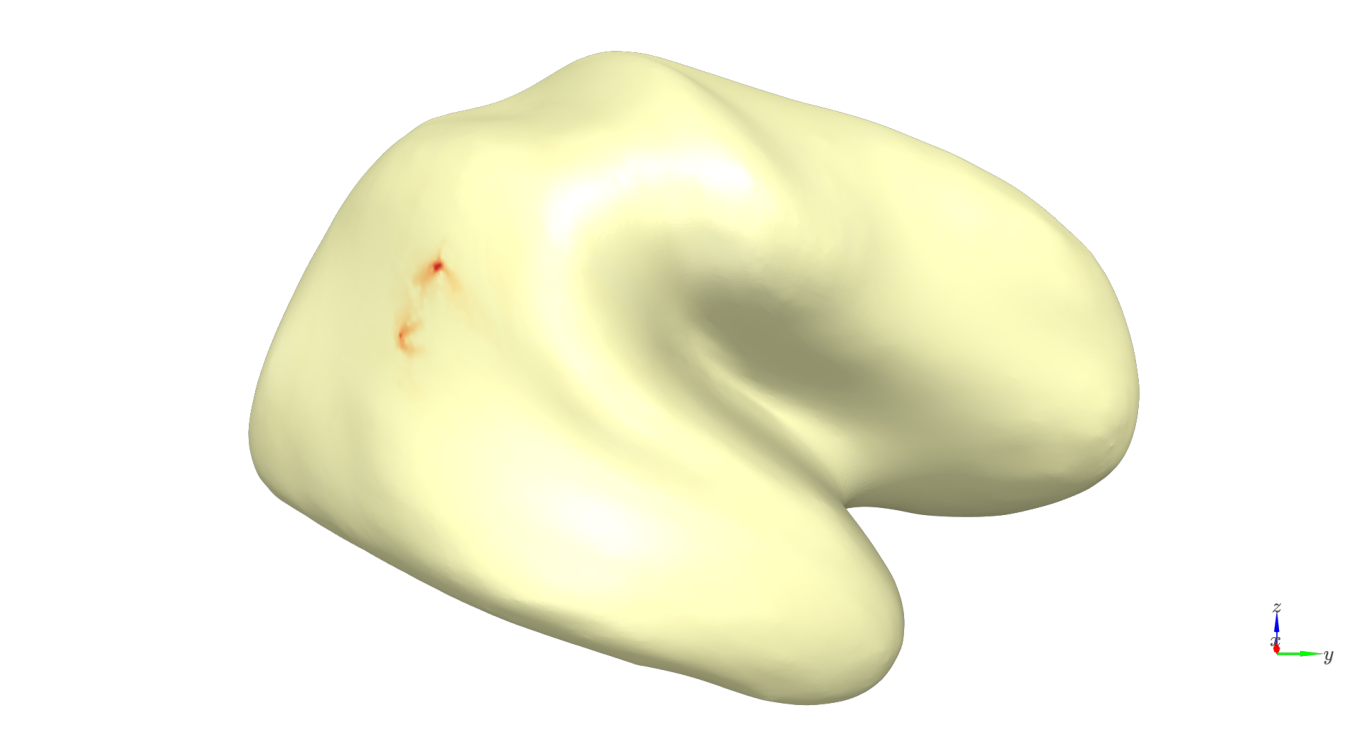

In [24]:
# Compute power in baseline and stimulus time periods
base_t_idx = np.where(time<0.5)[0]
exp_t_idx = np.where(time>=0.5)[0]

# Pial power
pial_base_power = np.squeeze(np.var(pial_layer_ts[:,base_t_idx,:],axis=1))
pial_exp_power = np.squeeze(np.var(pial_layer_ts[:,exp_t_idx,:],axis=1))
pial_power_change = (pial_exp_power-pial_base_power)/pial_base_power
m_pial_power_change = np.mean(pial_power_change,axis=-1)

# White matter power
white_base_power = np.squeeze(np.var(white_layer_ts[:,base_t_idx,:],axis=1))
white_exp_power = np.squeeze(np.var(white_layer_ts[:,exp_t_idx,:],axis=1))
white_power_change = (white_exp_power-white_base_power)/white_base_power
m_white_power_change = np.mean(white_power_change,axis=-1)

# Interpolate for display on the original inflated surface
pial_interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_pial_power_change)
white_interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_white_power_change)
          
# Plot colors and camera view
max_abs = np.max(np.abs(np.vstack([pial_interpolated_data, white_interpolated_data])))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot change in power on each surface
pial_colors,_ = color_map(
    pial_interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]
)
pial_plot = show_surface(orig_inflated, colors=pial_colors, info=True, camera_view=cam_view)

white_colors, c_map = color_map(
    white_interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)
white_plot = show_surface(orig_inflated, colors=white_colors, info=True, camera_view=cam_view)

Now we can defined the ROI based on where the change in power from baseline exceeds some percentile threshold in either the pial or the white matter surface

In [18]:
pial_t_statistic, pial_p_value = ttest_rel_corrected((pial_exp_power-pial_base_power), axis=-1)
white_t_statistic, white_p_value = ttest_rel_corrected((white_exp_power-white_base_power), axis=-1)

pial_thresh = np.percentile(pial_t_statistic, 99.99)
white_thresh = np.percentile(white_t_statistic, 99.99)
roi_idx = np.where((pial_t_statistic > pial_thresh) | (white_t_statistic > white_thresh))[0]

array([24446, 24588, 24589, 24711, 24723, 24836, 25498])

Finally we can average the change in power within the ROI, and compare the magnitude of the change between layers. The t-statistic here should be positive, indicating a greater change in power from baseline in the pial surface, because we simulated activity on the pial surface

In [20]:
pial_roi_power_change = np.mean(pial_power_change[roi_idx,:], axis=0)
white_roi_power_change = np.mean(white_power_change[roi_idx,:], axis=0)

# Compare power t statistic should be positive (more power in pial layer)
laminar_t_statistic, laminar_p_value = ttest_rel_corrected(
    np.abs(pial_roi_power_change)-np.abs(white_roi_power_change),
    axis=-1
)
print(f't({len(pial_roi_power_change)-1})={laminar_t_statistic}, p={laminar_p_value}')

t(61)=6.128231267852985, p=7.10817850932584e-08


## White matter surface simulation with pial - white matter ROI comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, there should be a greater change in power on the white matter surface.

In [21]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white.'

# Generate simulated data
white_sim_fname = run_current_density_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    dipole_moment,
    sim_patch_size, 
    SNR
)

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    white_sim_fname
)

# Run inversion on simulated data in a 5Hz window around the simulated frequency using the multilayer surface
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    white_sim_fname,
    n_layers, 
    foi=[freq-10, freq+10],
    patch_size=patch_size,
    n_temp_modes=n_temp_modes, 
    return_mu_matrix=True
)

# Get pial and white source time series
pial_layer_ts, time = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=pial_vertices
)
white_layer_ts, time = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=white_vertices
)

# Compute power in baseline and stimulus time periods
base_t_idx = np.where(time<0.5)[0]
exp_t_idx = np.where(time>=0.5)[0]

# Pial power
pial_base_power = np.squeeze(np.var(pial_layer_ts[:,base_t_idx,:],axis=1))
pial_exp_power = np.squeeze(np.var(pial_layer_ts[:,exp_t_idx,:],axis=1))
pial_power_change = (pial_exp_power-pial_base_power)/pial_base_power

# White matter power
white_base_power = np.squeeze(np.var(white_layer_ts[:,base_t_idx,:],axis=1))
white_exp_power = np.squeeze(np.var(white_layer_ts[:,exp_t_idx,:],axis=1))
white_power_change = (white_exp_power-white_base_power)/white_base_power

# Define ROI
pial_t_statistic, pial_p_value = ttest_rel_corrected((pial_exp_power-pial_base_power), axis=-1)
white_t_statistic, white_p_value = ttest_rel_corrected((white_exp_power-white_base_power), axis=-1)

pial_thresh = np.percentile(pial_t_statistic, 99.99)
white_thresh = np.percentile(white_t_statistic, 99.99)
roi_idx = np.where((pial_t_statistic > pial_thresh) | (white_t_statistic > white_thresh))[0]

# Compute power change within ROI
pial_roi_power_change = np.mean(pial_power_change[roi_idx,:], axis=0)
white_roi_power_change = np.mean(white_power_change[roi_idx,:], axis=0)

# Compare power t statistic should be negative (more power in white matter layer)
laminar_t_statistic, laminar_p_value = ttest_rel_corrected(
    np.abs(pial_roi_power_change)-np.abs(white_roi_power_change),
    axis=-1
)
print(f't({len(pial_roi_power_change)-1})={laminar_t_statistic}, p={laminar_p_value}')

Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
t(61)=-56.44813059898323, p=2.3026852515666362e-54


## Simulation in each layer with ROI power analysis across layers
That was the ROI analysis with two surfaces: the white matter and pial surfaces. Let's now simulate on each layer, and for each simulation, look at the change in power from baseline within the ROI across all layers. We'll turn off SPM visualization here.

In [25]:
# Compute power in baseline and stimulus time periods
base_t_idx = np.where(time<0.5)[0]
exp_t_idx = np.where(time>=0.5)[0]

# Now simulate at the corresponding vertex on each layer, and for each simulation, compute power in
# all layers
all_layerPow=[]

for sl in range(n_layers):
    print(f'Simulating in layer {sl}')
    l_vertex = sl*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}_{sl}.'

    l_sim_fname = run_current_density_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        dipole_moment, 
        sim_patch_size, 
        SNR, 
        viz=False
    ) 

    coregister(
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        multilayer_mesh_fname, 
        l_sim_fname, 
        viz=False
    )

    [_,_,MU] = invert_ebb(
        multilayer_mesh_fname, 
        l_sim_fname, 
        n_layers, 
        foi=[freq-10, freq+10], 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes, 
        return_mu_matrix=True, 
        viz=False
    )

    pial_layer_ts, time = load_source_time_series(
        l_sim_fname, 
        mu_matrix=MU, 
        vertices=pial_vertices
    )
    white_layer_ts, time = load_source_time_series(
        l_sim_fname, 
        mu_matrix=MU, 
        vertices=white_vertices
    )

    # Pial power
    pial_layer_base_power = np.squeeze(np.var(pial_layer_ts[:,base_t_idx,:],axis=1))
    pial_layer_exp_power = np.squeeze(np.var(pial_layer_ts[:,exp_t_idx,:],axis=1))
    # White matter power
    white_base_power = np.squeeze(np.var(white_layer_ts[:,base_t_idx,:],axis=1))
    white_exp_power = np.squeeze(np.var(white_layer_ts[:,exp_t_idx,:],axis=1))
    white_power_change = (white_exp_power-white_base_power)/white_base_power

    # Define ROI
    pial_t_statistic, pial_p_value = ttest_rel_corrected((pial_exp_power-pial_base_power), axis=-1)
    white_t_statistic, white_p_value = ttest_rel_corrected((white_exp_power-white_base_power), axis=-1)

    pial_thresh = np.percentile(pial_t_statistic, 99.99)
    white_thresh = np.percentile(white_t_statistic, 99.99)
    roi_idx = np.where((pial_t_statistic > pial_thresh) | (white_t_statistic > white_thresh))[0]

    roi_pow=[]
    for il in range(n_layers):
        layer_roi_verts = il*verts_per_surf+roi_idx
        layer_ts, time = load_source_time_series(l_sim_fname, mu_matrix=MU, vertices=layer_roi_verts.astype(int))
        
        layer_base_power = np.squeeze(np.var(layer_ts[:,base_t_idx,:],axis=1))
        layer_exp_power = np.squeeze(np.var(layer_ts[:,exp_t_idx,:],axis=1))
        layer_power_change = (layer_exp_power-layer_base_power)/layer_base_power

        roi_pow.append(np.abs(np.mean(layer_power_change,axis=0)))

    all_layerPow.append(roi_pow)
all_layerPow=np.array(all_layerPow)

Simulating in layer 0
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 1
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 2
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 3
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 4
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 5
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 6
Smoothing ../test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing
Simulating in layer 7
Smoothing ../test_o

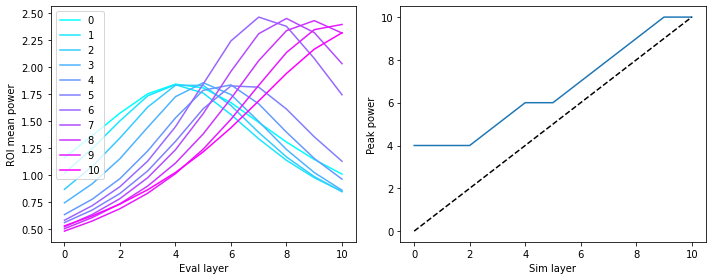

In [26]:
# Average power over trials
mean_layerPow=np.mean(all_layerPow,axis=-1)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the power in each layer model
plt.subplot(1,2,1)
for l in range(n_layers):
    layerPow=mean_layerPow[l,:]
    plt.plot(layerPow, label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel('ROI mean power')

# For each simulation, find which layer had the greatest power
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerPow=mean_layerPow[l,:]
    pk=np.argmax(layerPow)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel('Peak power')
plt.tight_layout()

In [27]:
# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)